Plotting a UnitIntervalMesh:


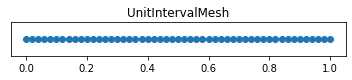

In [1]:
from dolfin import *
import numpy as np
parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

# Define mesh
mesh = UnitIntervalMesh(50)
#mesh = RectangleMesh(Point(0., 0.), Point(1., 0.1), 50, 5)

print("Plotting a UnitIntervalMesh:")
plt.figure()
plot(mesh, title="UnitIntervalMesh")

tol = 1E-12
# Sub domain for clamp at left end
def left(x, on_boundary):
    return near(x[0], 0.,tol) and on_boundary

# Sub domain for rotation at right end
def right(x, on_boundary):
    return near(x[0], 1.,tol) and on_boundary

# Set up boundary domains

In [2]:
# Create mesh function over the cell facets
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(right)
force_boundary.mark(boundary_subdomains, 3)

# Define measure for boundary condition integral
dss = ds(subdomain_data=boundary_subdomains)

In [3]:
E = Constant(70e3)
nu = Constant(0.3)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
sig0 = Constant((1e-6))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus
rho = Constant(5e4)

Nitermax, tol = 5, 1e-9  # parameters of the Newton-Raphson procedure
Nincr = 1600
load_steps = np.linspace(0, 16, Nincr+1)[1:]

dt = Constant(load_steps[1]-load_steps[0])
dt_ = float(dt)

# Newmark-beta method
betaN = Constant(0.25)
gammaN = Constant(0.5)

In [4]:
float(mu), float(dt)

(26923.076923076922, 0.01)

In [5]:
deg_u = 2
deg_stress = 2
V = FunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=1, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)
# Define function space for stresses
Vsig = VectorFunctionSpace(mesh, "DG", 0)

V_LM = VectorFunctionSpace(mesh, "CG", degree=deg_stress, dim=3)

L_activation = Function(V_LM)

In [6]:
sig = Function(W)
sig_old = Function(W)
beta = Function(W0)
gamma0 = Function(W0)
gamma0.interpolate(Constant(1e-5))
u = Function(V, name="Total displacement")
u_pre = Function(V)
u_old = Function(V)
u_d_old = Function(V)
u_dd_old = Function(V)
du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
u_ = TestFunction(V)

sig_out = Function(Vsig, name="sigma")
eps_out = Function(Vsig, name="epsilon")

In [7]:
# Set of variables for MPII model
N_MP = 30; # Number of yielding surface

Wne = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=N_MP, quad_scheme='default')
Wn = FunctionSpace(mesh, Wne)
# Wn = VectorFunctionSpace(mesh, "CG", degree=deg_stress, dim=3)

F_MP_n = Function(Wn)
alpha_MP_n = Function(Wn)
L_MP = Function(Wn)
k_MP_n = Function(Wn)

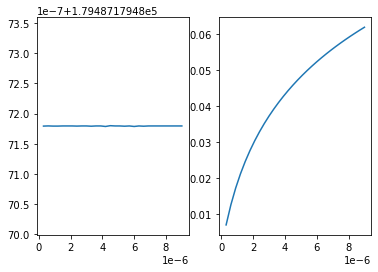

In [8]:
sample_MP = np.linspace(0.3,9,N_MP)
C_MP = np.zeros((N_MP,1))
k_MP = np.zeros((N_MP,))
# Generate yielding surface parameters with the bone curve
strain_ref_MP = 1e-6;
# Normalized bone curve function
def bone_MPII(strain):
    k_ = strain_ref_MP*np.log(1+strain/strain_ref_MP)
    G_ = 1/(1+strain/strain_ref_MP)
    return k_, G_

for i_sample in range(N_MP):
    k_MP[i_sample], G_n_MP = bone_MPII(sample_MP[i_sample]*strain_ref_MP)
    if i_sample > 0:
        C_MP[i_sample] = 1 / (1/2/mu/G_n_MP - 1/2/mu - np.sum(1/C_MP[0:i_sample]))
    else:
        C_MP[i_sample] = 1 / (1/2/mu/G_n_MP - 1/2/mu)
    # C_MP[i_sample] = G_n_MP

k_MP = k_MP*float(mu)
    
plt.subplot(1,2,1)
plt.plot(sample_MP*strain_ref_MP,C_MP)
plt.subplot(1,2,2)
plt.plot(sample_MP*strain_ref_MP,k_MP)
plt.show()

k_MP_n.interpolate(Constant(k_MP))

In [9]:
k_MP, C_MP

(array([0.00706365, 0.01265394, 0.01728068, 0.0212277 , 0.02466937,
        0.02772052, 0.03046083, 0.0329478 , 0.03522435, 0.03732331,
        0.0392704 , 0.04108613, 0.0427871 , 0.04438696, 0.04589706,
        0.04732694, 0.0486847 , 0.04997725, 0.05121059, 0.05238989,
        0.05351969, 0.05460399, 0.05564631, 0.05664977, 0.05761717,
        0.05855101, 0.05945354, 0.0603268 , 0.06117262, 0.06199268]),
 array([[179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.17948718],
        [179487.1794871

In [10]:
# sig.assign(Constant((1,)))
# Ones_ufl = Function(Wn)
# Ones_ufl = Constant(np.ones((N_MP,)))
# Ones_ufl.assign(Constant((0,0,0)))
# np.ones((N_MP,))/2 
# local_project(sig, Vsig, Ones_ufl)
# local_project(Ones_ufl, Wn, k_MP_n)
# print("k_MP_n: ",k_MP_n(0.8))

In [11]:
# Set up boundary condition at left end
zero = Constant(0.0)
bc = DirichletBC(V, zero, left)
# bc = [DirichletBC(V.sub(1), 0, facets, 1), DirichletBC(V.sub(0), 0, facets, 3)]
n = FacetNormal(mesh)
q_lim = float(2/sqrt(3)*sig0*mu*2)
# loading = Expression("q*t", q=q_lim, t=0, degree=2)
loading = Expression(("t <= tc ? q*t*(1-t)*4 : 0"), q=0.5*q_lim, t=0, tc=1.2, degree=2)
# p = Expression(("t <= tc ? p0*t/tc : 0", "0", "0"), t=0, tc=cutoff_Tc, p0=p0, degree=0)

def F_ext(v):
    return dot(loading,v)*dss(3)
    # return loading*dot(n, v)*dss(3)

In [12]:
# Update formula for acceleration
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
def update_a(u, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        betaN_ = betaN
    else:
        dt_ = float(dt)
        betaN_ = float(betaN)
    return (u-u_old-dt_*v_old)/betaN_/dt_**2 - (1-2*betaN_)/2/betaN_*a_old

# Update formula for velocity
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
def update_v(a, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        gamma_ = gammaN
    else:
        dt_ = float(dt)
        gamma_ = float(gammaN)
    return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

def update_fields(u, u_old, v_old, a_old):
    """Update fields at the end of each time step."""

    # Get vectors (references)
    u_vec, u0_vec  = u.vector(), u_old.vector()
    v0_vec, a0_vec = v_old.vector(), a_old.vector()

    # use update functions using vector arguments
    a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

    # Update (u_old <- u)
    v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
    u_old.vector()[:] = u.vector()

In [13]:
def eps(v):
    e = 0.5*grad(v)
    return e

def sigma(eps_el):
    return 2*mu*eps_el

def sigma_out(r):
    return 2.0*mu*sym(grad(r))

In [14]:
tol_err = 1e10
def proj_sig(old_u,old_sig,old_Du,old_alpha_MP_n):
    deps_old = eps(old_Du)
    dsig = sigma_tang(deps_old)
    sig_new = dsig+old_sig
    L_MP = (abs( abs( sig_new[0]*Ones_ufl - old_alpha_MP_n) - k_MP_n ) \
               + abs( sig_new[0]*Ones_ufl - old_alpha_MP_n) - k_MP_n ) / 2
    alpha_MP_n = old_alpha_MP_n + (L_MP)*abs(deps_old[0]*tol_err)/(tol_err*deps_old[0])
    return dsig+old_sig, alpha_MP_n


In [15]:
ppos = lambda x: (x+abs(x))/2.

Ones_ufl = Function(Wn)
Ones_ufl.interpolate(Constant( np.ones((N_MP,)) ))

def activation(Du,sig_old,alpha_MP_old):
    # L_MP_array = np.zeros((N_MP,))
    sig_new = 2*mu*eps(Du) + sig_old
    L_MP = (abs( abs( sig_new[0]*Ones_ufl - alpha_MP_old) - k_MP_n ) \
               + abs( sig_new[0]*Ones_ufl - alpha_MP_old) - k_MP_n ) / 2
        # L_MP[i_n] = conditional(gt(judge_act,0), 1, 0)
        # if judge_act > 0:
        #     L_MP[i_n] = 1
        # else:
        #     L_MP[i_n] = 0
    return L_MP


In [16]:
# Ones_ufl(1)
# (abs(eps(Du)[0])/eps(Du)[0]*L_MP).ufl_shape

In [17]:
tol_err = 1e-10
def sigma_tang(e):
    inv_modulus = 1/2/mu
    for i_n in range(N_MP):
        inv_modulus += L_MP[i_n]/C_MP[i_n]/(L_MP[i_n]+tol_err)
    modulus = 1/inv_modulus
    return modulus[0]*e

In [18]:
sigma_tang(eps(v)).ufl_shape, eps(u_).ufl_shape

((1,), (1,))

In [19]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

# a_Newton = inner(eps(v), sigma_tang(eps(u_)))*dxm

# a_Newton = inner(eps(u_), sigma_tang(eps(v)))*dxm

a_Newton = rho*inner(u_,v)/(betaN*dt*dt)*dxm + inner(eps(u_), sigma_tang(eps(v)) )*dxm

res = (-rho)*inner(u_,u)/(betaN*dt*dt)*dxm + \
      -inner(eps(u_), sig)*dxm + \
      F_ext(u_) + \
      rho*inner(u_old+dt*u_d_old,u_)*1./(betaN*dt*dt)*dxm + \
      (1.-2*betaN)/(2*betaN)*rho*inner(u_dd_old,u_)*dxm

In [20]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dxm
    b_proj = inner(v, v_)*dxm
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [21]:
file_results = XDMFFile("plasticity_results.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

In [22]:
results = np.zeros((Nincr+1, 5))
results_1d = np.zeros((Nincr+1, 50))
results_2d = np.zeros((Nincr+1, N_MP))
for (i, t) in enumerate(load_steps):
    loading.t = t
    A, Res = assemble_system(a_Newton, res, bc)
    nRes0 = Res.norm("l2")
    nRes = nRes0
    Du.interpolate(Constant(0))
    print("Increment:", str(i+1),"   Initial Residual:", nRes0)
    niter = 0
    u_pre.assign(u)
    # local_project(k_MP_n, V_LM, L_activation)
    # print("k_MP_n: ",k_MP_n(1))
    # local_project(L_MP, V_LM, L_activation)
    # print("Activation: ",L_MP(1))
    # print("alpha_MP_n: ",alpha_MP_n(1))
    while (nRes/nRes0 > tol and nRes0>1e-10) and niter < Nitermax:
        solve(A, du.vector(), Res, "mumps")
        Du.assign(Du+du)
        u.assign(u+du) # u^{k+1}_{n+1}
        L_MP_ = activation(Du,sig_old,alpha_MP_n)
        local_project(L_MP_, Wn, L_MP)
        sig_, alpha_MP_n_ = proj_sig(u_pre,sig_old,Du,alpha_MP_n)
        local_project(sig_, W, sig)
        local_project(alpha_MP_n_, Wn, alpha_MP_n)
        A, Res = assemble_system(a_Newton, res, bc)
        nRes = Res.norm("l2")
        print("    Residual:", nRes," ",niter)
        niter += 1
    u.assign(u_pre+Du)
    
    update_fields(u, u_old, u_d_old, u_dd_old)
    
    sig_old.assign(sig)
    
# ----------------
# Post-processing
# ----------------
#
# Inside the incremental loop, the displacement and plastic strains are exported
# at each time increment, the plastic strain must first be projected onto the
# previously defined DG FunctionSpace. We also monitor the value of the cylinder
# displacement on the inner boundary. The load-displacement curve is then plotted::

    local_project(sig, Vsig, sig_out)
    local_project(eps(u), Vsig, eps_out)
    # local_project(alpha_MP_n, V_LM, L_activation)
    # print("alpha_MP_n: ",alpha_MP_n[0](1))
    # local_project(L_MP, V_LM, L_activation)
    # print("Activation: ",L_MP(1))
    
    file_results.write(u, t)
    
    # results_2d[i+1,:] = L_MP(1)[:]
    for i_x in range(50):
        results_1d[i+1,i_x] = u(i_x/50)
    tc = 1.2;
    if t<tc:
        # results[i+1, :] = (u(1),t,4*t*(1-t))
        results[i+1, :] = (u(1), sig_out(1),t,4*t*(1-t),eps_out(1))
    else:
        results[i+1, :] = (u(1), sig_out(1),t,0,eps_out(1))


Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.


/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/quadrature/quadraturerepresentation.py:58: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


Increment: 1    Initial Residual: 0.001231088420148956
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.


/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.
    Residual: 7.808617963819405e-12   0
    Residual: 7.808617987687322e-12   1
    Residual: 2.2395554515764117e-19   2
Increment: 2    Initial Residual: 0.005218894235400619
    Residual: 6.262302752494717e-12   0
    Residual: 6.2623023088643516e-12   1
    Residual: 1.8786908816000264e-11   2
    Residual: 4.383611675533384e-11   3
    Residual: 4.383611827791668e-11   4
Increment: 3    Initial Residual: 0.0129294692126027
    Residual: 2.2946667724701294e-11   0
    Residual: 3.033852961738974e-11   1
    Residual: 8.136737948831741e-12   2
Increment: 4    Initial Residual: 0.023192508984165115
    Residual: 0.0004424965986649925   0
    Residual: 6.583

    Residual: 6.780211061615645e-05   0
    Residual: 5.839803912786383e-11   1
Increment: 61    Initial Residual: 1.3304466258699728
    Residual: 0.00016716477497224024   0
    Residual: 6.91710340205501e-05   1
    Residual: 2.859017135583964e-10   2
Increment: 62    Initial Residual: 1.347192290756828
    Residual: 5.7179588149819336e-05   0
    Residual: 6.596973546791609e-11   1
Increment: 63    Initial Residual: 1.3632937778869862
    Residual: 0.000530779757260603   0
    Residual: 1.177831885034383e-10   1
Increment: 64    Initial Residual: 1.3787512507659885
    Residual: 0.00010214807925879472   0
    Residual: 5.45444842465569e-11   1
Increment: 65    Initial Residual: 1.393603200126845
    Residual: 0.00010841101750191678   0
    Residual: 1.0138746629757217e-09   1
Increment: 66    Initial Residual: 1.407752403665102
    Residual: 0.00015847443588611952   0
    Residual: 5.94307548458079e-11   1
Increment: 67    Initial Residual: 1.4212445475467885
    Residual: 0.0003811

    Residual: 0.00020399029214887798   0
    Residual: 2.5125392668495263e-10   1
Increment: 118    Initial Residual: 1.3531189530285674
    Residual: 0.000761161444836345   0
    Residual: 2.1347643494790637e-05   1
    Residual: 5.7965541689659024e-11   2
Increment: 119    Initial Residual: 1.3571338731047202
    Residual: 0.00116593901308754   0
    Residual: 8.712572206549514e-05   1
    Residual: 1.1158465430470571e-10   2
Increment: 120    Initial Residual: 1.3635872585585254
    Residual: 0.0005788464561463539   0
    Residual: 1.6868471561943717e-10   1
Increment: 121    Initial Residual: 1.368879163043592
    Residual: 0.015845065049835887   0
    Residual: 0.005045592914802025   1
    Residual: 0.0001450905079107597   2
    Residual: 1.2468021396364995e-10   3
Increment: 122    Initial Residual: 1.3638416802009234
    Residual: 0.017726088662894685   0
    Residual: 0.004639236839199609   1
    Residual: 0.0028655586940788897   2
    Residual: 0.0006109019838414387   3
    Re

    Residual: 0.0020278958789866565   0
    Residual: 5.75656923959708e-05   1
    Residual: 1.3575227377934818e-10   2
Increment: 165    Initial Residual: 1.0813461343917867
    Residual: 0.0014992397011954325   0
    Residual: 3.916095108253435e-05   1
    Residual: 1.2508176015234212e-10   2
Increment: 166    Initial Residual: 1.0754084617908977
    Residual: 0.002007328478685794   0
    Residual: 4.871673409897979e-05   1
    Residual: 1.3457489613596602e-10   2
Increment: 167    Initial Residual: 1.0702197051907711
    Residual: 0.0016552389959677458   0
    Residual: 0.00015131062446428298   1
    Residual: 8.589564205711665e-10   2
Increment: 168    Initial Residual: 1.0645697281830167
    Residual: 0.0018133242419838514   0
    Residual: 0.0001073758113708217   1
    Residual: 2.1819500573569778e-10   2
Increment: 169    Initial Residual: 1.0594208291357625
    Residual: 0.0016532825125678855   0
    Residual: 0.000112831178040853   1
    Residual: 3.542993426888649e-10   2
Inc

Increment: 211    Initial Residual: 0.8777429049100455
    Residual: 0.0014916342985134266   0
    Residual: 0.00010080387673540971   1
    Residual: 1.0388599625700188e-10   2
Increment: 212    Initial Residual: 0.8740863740808904
    Residual: 0.00112025477666695   0
    Residual: 0.0002271373452891654   1
    Residual: 7.08560093535718e-06   2
    Residual: 1.159866338715957e-10   3
Increment: 213    Initial Residual: 0.8693265099855362
    Residual: 0.001441949586100429   0
    Residual: 0.0001222691813944299   1
    Residual: 5.689772822092901e-09   2
    Residual: 1.7041251507281102e-10   3
Increment: 214    Initial Residual: 0.8656575556682787
    Residual: 0.0012007773497963465   0
    Residual: 9.88091763096242e-05   1
    Residual: 8.920841897363934e-11   2
Increment: 215    Initial Residual: 0.8610836684806197
    Residual: 0.0018486050630537292   0
    Residual: 8.131116728556768e-05   1
    Residual: 1.3993177583996014e-10   2
Increment: 216    Initial Residual: 0.85735484

    Residual: 0.00013789131510429057   1
    Residual: 2.506568231817555e-09   2
    Residual: 5.6224462707453584e-11   3
Increment: 260    Initial Residual: 0.643094523517559
    Residual: 0.0007997322875966368   0
    Residual: 7.03123672721081e-05   1
    Residual: 4.784560821617897e-10   2
Increment: 261    Initial Residual: 0.6355312425717305
    Residual: 0.0005617503878127777   0
    Residual: 0.000159051476059302   1
    Residual: 7.640445180874435e-11   2
Increment: 262    Initial Residual: 0.6281744190035334
    Residual: 0.0005297082596808666   0
    Residual: 2.4131434938947573e-05   1
    Residual: 3.595664147786974e-05   2
    Residual: 4.344036074442599e-10   3
Increment: 263    Initial Residual: 0.6204342443117294
    Residual: 0.0007744633298375649   0
    Residual: 9.674907701701298e-05   1
    Residual: 7.070408105107287e-11   2
Increment: 264    Initial Residual: 0.6127228448726806
    Residual: 0.001104784553277647   0
    Residual: 0.0003063642539618441   1
    Re

    Residual: 0.0011697446204408687   0
    Residual: 0.00015827470726560833   1
    Residual: 6.478150907642718e-11   2
Increment: 307    Initial Residual: 0.2928710355262724
    Residual: 0.0011064595275647629   0
    Residual: 0.0002406661662415035   1
    Residual: 9.369373128519753e-11   2
Increment: 308    Initial Residual: 0.28789967218302803
    Residual: 0.0010837517157793034   0
    Residual: 0.00015961937584828918   1
    Residual: 8.902168236898151e-11   2
Increment: 309    Initial Residual: 0.28258921181081376
    Residual: 0.0005724290798495175   0
    Residual: 0.00014727185586155885   1
    Residual: 1.382459890957085e-10   2
Increment: 310    Initial Residual: 0.2771790519745221
    Residual: 0.00044508310153377545   0
    Residual: 1.5719658358468378e-05   1
    Residual: 7.034707860168509e-11   2
Increment: 311    Initial Residual: 0.2727156082427551
    Residual: 0.000631762495565275   0
    Residual: 0.00033736267054688604   1
    Residual: 1.643915296411558e-05   

    Residual: 0.0003670060481044985   0
    Residual: 1.1413570447451895e-05   1
    Residual: 1.084924855166685e-10   2
Increment: 361    Initial Residual: 0.3028590492529077
    Residual: 0.00033344718166126004   0
    Residual: 2.9955487797805887e-06   1
    Residual: 1.0469434805587916e-10   2
Increment: 362    Initial Residual: 0.302158260569188
    Residual: 0.0003931398183915614   0
    Residual: 3.991398087925759e-06   1
    Residual: 8.594793625315133e-11   2
Increment: 363    Initial Residual: 0.30027711275148394
    Residual: 0.00041688247581460287   0
    Residual: 2.5357866560306637e-05   1
    Residual: 9.649134737736868e-11   2
Increment: 364    Initial Residual: 0.2990632879956873
    Residual: 0.000306574776616963   0
    Residual: 4.768663746767106e-05   1
    Residual: 2.102418810883432e-09   2
    Residual: 8.905364196615879e-11   3
Increment: 365    Initial Residual: 0.29723366904375503
    Residual: 0.0003672253143034869   0
    Residual: 4.779623916172914e-10   1

    Residual: 0.0003481704439024134   0
    Residual: 8.67192698894932e-06   1
    Residual: 8.21266726948848e-11   2
Increment: 409    Initial Residual: 0.27815374796489173
    Residual: 0.00040581802350212896   0
    Residual: 2.4628131787909497e-06   1
    Residual: 8.556355591343944e-11   2
Increment: 410    Initial Residual: 0.2787228571869558
    Residual: 0.00036054319959490555   0
    Residual: 2.7327116124289442e-05   1
    Residual: 2.450589157630632e-10   2
Increment: 411    Initial Residual: 0.2789199123670201
    Residual: 0.0003315893043602266   0
    Residual: 1.9537323494642626e-05   1
    Residual: 1.1194947341093231e-10   2
Increment: 412    Initial Residual: 0.2795663594994756
    Residual: 0.00030672141314176416   0
    Residual: 8.123989922556746e-06   1
    Residual: 7.637319738404026e-11   2
Increment: 413    Initial Residual: 0.2800180622832113
    Residual: 0.00039878178191884626   0
    Residual: 1.3558409324943809e-05   1
    Residual: 8.325783668677113e-11  

    Residual: 0.00029987494519719617   0
    Residual: 1.121362140832618e-07   1
    Residual: 6.69479284515361e-11   2
Increment: 455    Initial Residual: 0.32672974830630247
    Residual: 0.0002837106258717286   0
    Residual: 1.5700754863044889e-06   1
    Residual: 6.553430407883054e-11   2
Increment: 456    Initial Residual: 0.32875447474759395
    Residual: 0.0003275921217935716   0
    Residual: 7.946534296474735e-07   1
    Residual: 7.80080137345943e-11   2
Increment: 457    Initial Residual: 0.3306640148275241
    Residual: 0.00032415541184533536   0
    Residual: 9.454743370455537e-06   1
    Residual: 1.080896155924891e-05   2
    Residual: 8.106018619236052e-11   3
Increment: 458    Initial Residual: 0.33301921504839016
    Residual: 0.0002623261419365777   0
    Residual: 4.883945602019502e-10   1
    Residual: 8.932332071420938e-11   2
Increment: 459    Initial Residual: 0.3349439836098508
    Residual: 0.0003051210731356204   0
    Residual: 3.4225451814702805e-06   1


    Residual: 1.5994486998299766e-10   1
Increment: 504    Initial Residual: 0.47313587366700427
    Residual: 0.00022701034176038327   0
    Residual: 1.9584288204131675e-06   1
    Residual: 5.802877588855501e-11   2
Increment: 505    Initial Residual: 0.47579596981854394
    Residual: 0.00029254957041859725   0
    Residual: 9.928509701772319e-06   1
    Residual: 7.708592094958231e-11   2
Increment: 506    Initial Residual: 0.47801750627170014
    Residual: 0.0002615546941097958   0
    Residual: 6.463788520842083e-06   1
    Residual: 5.729456773627234e-11   2
Increment: 507    Initial Residual: 0.4804854663172845
    Residual: 0.00027336321833064327   0
    Residual: 1.1765229309470035e-05   1
    Residual: 5.135915219221267e-11   2
Increment: 508    Initial Residual: 0.48258729726674826
    Residual: 0.00027223723581232864   0
    Residual: 5.322797024163824e-05   1
    Residual: 2.865244104015842e-10   2
Increment: 509    Initial Residual: 0.48498530768094367
    Residual: 0.00

    Residual: 0.00030435889115940367   0
    Residual: 2.7286770871850083e-05   1
    Residual: 7.249148062047441e-11   2
Increment: 557    Initial Residual: 0.5083912868144189
    Residual: 0.00027522673546297416   0
    Residual: 1.6691069705661846e-05   1
    Residual: 8.397675861643776e-11   2
Increment: 558    Initial Residual: 0.5085337250498301
    Residual: 0.0002952382080730969   0
    Residual: 2.4720168719598446e-05   1
    Residual: 8.233225091532501e-11   2
Increment: 559    Initial Residual: 0.508979369801705
    Residual: 0.0002875824598178893   0
    Residual: 6.269153979464635e-05   1
    Residual: 2.710381023172359e-10   2
Increment: 560    Initial Residual: 0.5092542432238337
    Residual: 0.0002950463825110845   0
    Residual: 3.101815096557367e-05   1
    Residual: 7.657552980033229e-11   2
Increment: 561    Initial Residual: 0.5097267152946532
    Residual: 0.00031901019679356956   0
    Residual: 1.1736385336605305e-05   1
    Residual: 7.459285556927234e-11   2

    Residual: 0.00040405027543964953   0
    Residual: 2.3960388553587892e-05   1
    Residual: 6.965337853574305e-11   2
Increment: 604    Initial Residual: 0.5207692026140283
    Residual: 0.00043755997341608907   0
    Residual: 5.259819730582583e-05   1
    Residual: 6.924716057378766e-11   2
Increment: 605    Initial Residual: 0.5205218051795157
    Residual: 0.0004374742766173974   0
    Residual: 2.0548502458665926e-05   1
    Residual: 9.533431103357121e-11   2
Increment: 606    Initial Residual: 0.5210046519398711
    Residual: 0.00042257887372180975   0
    Residual: 3.1322070274578646e-05   1
    Residual: 6.02614525290868e-11   2
Increment: 607    Initial Residual: 0.5206794289985123
    Residual: 0.0005066718412786677   0
    Residual: 3.514284667657796e-05   1
    Residual: 5.483791808688697e-11   2
Increment: 608    Initial Residual: 0.5211837287923385
    Residual: 0.0003985447978200296   0
    Residual: 3.808053545217069e-05   1
    Residual: 2.2652895429085394e-05   2

    Residual: 5.0806776768516466e-05   1
    Residual: 4.75629015047487e-11   2
Increment: 650    Initial Residual: 0.5150337436156844
    Residual: 0.0003381250728346019   0
    Residual: 3.641076507679591e-05   1
    Residual: 1.1393224662240557e-10   2
Increment: 651    Initial Residual: 0.5144417102204296
    Residual: 0.00022249441445233235   0
    Residual: 2.8010421570325416e-05   1
    Residual: 4.0758896235018956e-11   2
Increment: 652    Initial Residual: 0.5139290933801703
    Residual: 0.0003255031398363739   0
    Residual: 2.8791883786144327e-05   1
    Residual: 4.477741310994535e-11   2
Increment: 653    Initial Residual: 0.5133657215987119
    Residual: 0.00037506399927381227   0
    Residual: 2.9153542508732575e-05   1
    Residual: 3.476250997223498e-11   2
Increment: 654    Initial Residual: 0.5127498845952035
    Residual: 0.0004185531311454859   0
    Residual: 6.243163117627199e-05   1
    Residual: 3.0277293604595946e-05   2
    Residual: 2.3141073398469205e-11 

    Residual: 0.00012117876298660732   0
    Residual: 1.213086683681078e-10   1
Increment: 700    Initial Residual: 0.4565020836139019
    Residual: 0.00012086295057510753   0
    Residual: 5.5483472030617295e-11   1
Increment: 701    Initial Residual: 0.4546459377271694
    Residual: 0.0003627306583951745   0
    Residual: 5.877608942424649e-05   1
    Residual: 2.8679826646060906e-05   2
    Residual: 3.818045478225076e-11   3
Increment: 702    Initial Residual: 0.4525036091392464
    Residual: 0.00031799415076071407   0
    Residual: 3.214597468889615e-06   1
    Residual: 2.9064647996141192e-11   2
Increment: 703    Initial Residual: 0.450583334236746
    Residual: 0.00016487096482011715   0
    Residual: 3.5995811999565913e-10   1
Increment: 704    Initial Residual: 0.4484153775104129
    Residual: 0.00011608890824592755   0
    Residual: 7.187930555258235e-06   1
    Residual: 2.477992194937944e-11   2
Increment: 705    Initial Residual: 0.4464337667577748
    Residual: 9.311070

    Residual: 0.0003342034034265   0
    Residual: 1.1238474081148533e-05   1
    Residual: 4.40123691579896e-11   2
Increment: 755    Initial Residual: 0.339021798960889
    Residual: 0.00032224074970000705   0
    Residual: 4.274921363936763e-10   1
    Residual: 4.1571092290519986e-11   2
Increment: 756    Initial Residual: 0.33745573355261865
    Residual: 0.0003183076927189481   0
    Residual: 2.1749628175314555e-05   1
    Residual: 5.586135799794088e-11   2
Increment: 757    Initial Residual: 0.3350839230442915
    Residual: 0.00030157696313452874   0
    Residual: 2.847852764609144e-05   1
    Residual: 3.637333504479841e-11   2
Increment: 758    Initial Residual: 0.33346941792212415
    Residual: 0.00019112347631961886   0
    Residual: 2.1650583137335777e-06   1
    Residual: 3.029104128894242e-11   2
Increment: 759    Initial Residual: 0.33119631549644807
    Residual: 0.0001766356446008144   0
    Residual: 1.9408225851058024e-09   1
    Residual: 2.939671346298678e-11   2

    Residual: 5.059986833759579e-05   1
    Residual: 5.837484499413948e-11   2
Increment: 802    Initial Residual: 0.2379736222093431
    Residual: 0.0002869797644059708   0
    Residual: 4.357654259203239e-05   1
    Residual: 6.368797693376231e-10   2
    Residual: 3.6964151001541716e-11   3
Increment: 803    Initial Residual: 0.2357335403068046
    Residual: 0.00013991232887913487   0
    Residual: 2.2914157484646773e-09   1
    Residual: 2.8191513337007543e-11   2
Increment: 804    Initial Residual: 0.2330024809970769
    Residual: 0.0001959633270985225   0
    Residual: 9.425306831809811e-06   1
    Residual: 2.978583375539737e-11   2
Increment: 805    Initial Residual: 0.23083093172679411
    Residual: 0.00030724685207093926   0
    Residual: 6.102334806065361e-06   1
    Residual: 3.2569554845097886e-11   2
Increment: 806    Initial Residual: 0.22802614821315018
    Residual: 0.0004055853235801294   0
    Residual: 6.004722765967027e-05   1
    Residual: 4.821642737245671e-11  

    Residual: 9.796239997984152e-11   2
Increment: 852    Initial Residual: 0.10294876296247704
    Residual: 0.00027267453848805697   0
    Residual: 1.733159913004429e-05   1
    Residual: 6.210090657019587e-11   2
Increment: 853    Initial Residual: 0.10031327661149
    Residual: 0.0002055939590374857   0
    Residual: 8.027504088191982e-05   1
    Residual: 2.0913904730777862e-05   2
    Residual: 9.744468688504243e-11   3
Increment: 854    Initial Residual: 0.09714528097691236
    Residual: 0.00018769521486689642   0
    Residual: 1.582622564530525e-05   1
    Residual: 2.7090085102889433e-11   2
Increment: 855    Initial Residual: 0.09445318124888652
    Residual: 0.00016433710579949291   0
    Residual: 2.1747135204912656e-06   1
    Residual: 2.164037129242185e-11   2
Increment: 856    Initial Residual: 0.09131400711027653
    Residual: 0.00021584940252159697   0
    Residual: 4.750448133360402e-10   1
    Residual: 3.724985211681814e-11   2
Increment: 857    Initial Residual: 

    Residual: 0.0001451046260305181   0
    Residual: 1.5027444886527363e-05   1
    Residual: 4.289485548363877e-11   2
    Residual: 4.198267870180187e-11   3
    Residual: 5.282128725070724e-11   4
Increment: 896    Initial Residual: 0.04080816932035198
    Residual: 4.221683667503447e-05   0
    Residual: 6.877880764882391e-11   1
    Residual: 4.371762910165732e-11   2
    Residual: 3.306087937013323e-11   3
Increment: 897    Initial Residual: 0.04315958072925071
    Residual: 6.550061949969416e-05   0
    Residual: 1.5598313980443994e-08   1
    Residual: 4.728298731535383e-09   2
    Residual: 2.056428469873869e-09   3
    Residual: 1.0312376992307654e-09   4
Increment: 898    Initial Residual: 0.045700635028555495
    Residual: 3.089711046302148e-05   0
    Residual: 3.922916472894656e-11   1
Increment: 899    Initial Residual: 0.04856749665335419
    Residual: 0.0002053469973003606   0
    Residual: 5.172236227610039e-11   1
    Residual: 4.310873398815014e-11   2
Increment: 9

    Residual: 3.682737955045211e-11   0
Increment: 979    Initial Residual: 0.24688750733962073
    Residual: 4.0976293675513974e-11   0
Increment: 980    Initial Residual: 0.24889039562622572
    Residual: 3.292294480625987e-11   0
Increment: 981    Initial Residual: 0.2503783913817309
    Residual: 2.938148465171109e-11   0
Increment: 982    Initial Residual: 0.2524072955417087
    Residual: 3.063918045253007e-11   0
Increment: 983    Initial Residual: 0.25381675481441685
    Residual: 3.5329815194419425e-11   0
Increment: 984    Initial Residual: 0.25586706699099176
    Residual: 3.668856426990411e-11   0
Increment: 985    Initial Residual: 0.25726141420670745
    Residual: 3.835288192331627e-11   0
Increment: 986    Initial Residual: 0.2593271766088851
    Residual: 2.7660339383870317e-11   0
Increment: 987    Initial Residual: 0.26066880769987855
    Residual: 3.0560830021164744e-11   0
Increment: 988    Initial Residual: 0.2627111871705417
    Residual: 2.0220692927316443e-11   0

    Residual: 4.963671775779316e-06   1
    Residual: 2.1601330942635462e-11   2
Increment: 1066    Initial Residual: 0.34466486355680054
    Residual: 5.184827180519325e-05   0
    Residual: 9.236873079779588e-11   1
Increment: 1067    Initial Residual: 0.3452105343175894
    Residual: 1.7114814464937337e-10   0
Increment: 1068    Initial Residual: 0.34512727503933077
    Residual: 3.463572082761222e-11   0
Increment: 1069    Initial Residual: 0.3455925193837572
    Residual: 5.942654649568908e-05   0
    Residual: 6.045401238766936e-06   1
    Residual: 1.627866138432238e-11   2
Increment: 1070    Initial Residual: 0.3455330857833024
    Residual: 6.309846504560096e-05   0
    Residual: 8.446963957116904e-11   1
Increment: 1071    Initial Residual: 0.3459160038297092
    Residual: 2.3739724418786855e-10   0
Increment: 1072    Initial Residual: 0.34585975086956455
    Residual: 2.558172497866943e-11   0
Increment: 1073    Initial Residual: 0.3461747646219861
    Residual: 2.4782538576

    Residual: 0.00013864100168614024   0
    Residual: 5.758419828719044e-06   1
    Residual: 7.782305765315016e-11   2
Increment: 1122    Initial Residual: 0.32469485376731183
    Residual: 0.0001336536246802809   0
    Residual: 2.7862717005678765e-06   1
    Residual: 4.131406232469671e-11   2
Increment: 1123    Initial Residual: 0.3235210673950492
    Residual: 0.00010816903884437539   0
    Residual: 3.88140357646222e-06   1
    Residual: 7.4492411766097376e-06   2
    Residual: 1.3524332438747296e-11   3
Increment: 1124    Initial Residual: 0.32287462097664726
    Residual: 8.81823140090596e-05   0
    Residual: 3.830121472303202e-06   1
    Residual: 4.0224904971434124e-11   2
Increment: 1125    Initial Residual: 0.32166508487845463
    Residual: 0.00011258414650599727   0
    Residual: 3.2158336127707578e-06   1
    Residual: 4.5244455957522883e-11   2
Increment: 1126    Initial Residual: 0.3209969820177981
    Residual: 0.00015159802908582982   0
    Residual: 4.2788125460789

    Residual: 5.93648247842529e-11   2
Increment: 1169    Initial Residual: 0.26633251326317076
    Residual: 0.00013711460468569255   0
    Residual: 5.912698496459603e-06   1
    Residual: 5.4549944517168837e-11   2
Increment: 1170    Initial Residual: 0.2649433317802774
    Residual: 0.00012201464300942782   0
    Residual: 5.880190609473918e-06   1
    Residual: 8.769503376332545e-11   2
Increment: 1171    Initial Residual: 0.2632821378043314
    Residual: 0.00013661164125783128   0
    Residual: 7.302602336638947e-06   1
    Residual: 6.015758719020276e-11   2
Increment: 1172    Initial Residual: 0.26186051709636954
    Residual: 0.00012241340854006398   0
    Residual: 8.84204668579525e-08   1
    Residual: 4.151465705078384e-11   2
Increment: 1173    Initial Residual: 0.26023002233576625
    Residual: 0.00010109960576735804   0
    Residual: 3.0470986071800794e-10   1
    Residual: 3.630085597263606e-11   2
Increment: 1174    Initial Residual: 0.25874893076165306
    Residual: 9

    Residual: 2.44449457059676e-11   3
Increment: 1216    Initial Residual: 0.18642225745031474
    Residual: 0.0001198586487513982   0
    Residual: 3.034138272518369e-10   1
    Residual: 4.7444569502266e-11   2
Increment: 1217    Initial Residual: 0.18494236274081413
    Residual: 9.94804425753365e-05   0
    Residual: 9.787185585372605e-06   1
    Residual: 4.711148925668021e-11   2
Increment: 1218    Initial Residual: 0.18267826111673519
    Residual: 8.500651580772145e-05   0
    Residual: 3.802546154364005e-06   1
    Residual: 3.815674185671732e-09   2
    Residual: 2.9976819606621514e-10   3
    Residual: 3.4683409157250137e-11   4
Increment: 1219    Initial Residual: 0.181160686852948
    Residual: 7.362937437313083e-05   0
    Residual: 3.7797890949986123e-06   1
    Residual: 3.7306137519800424e-11   2
Increment: 1220    Initial Residual: 0.1788938107225281
    Residual: 9.192694009903376e-05   0
    Residual: 2.1035763984603647e-06   1
    Residual: 6.060843425086025e-11  

    Residual: 0.00010271970600266806   0
    Residual: 4.19987800709031e-06   1
    Residual: 4.3883222226416265e-11   2
Increment: 1263    Initial Residual: 0.0880672745493248
    Residual: 7.028008032225508e-05   0
    Residual: 8.490671647697308e-06   1
    Residual: 4.1492133334376835e-11   2
Increment: 1264    Initial Residual: 0.08606636464965109
    Residual: 2.9708459746455686e-05   0
    Residual: 2.4294888489520815e-06   1
    Residual: 2.878758408144018e-11   2
Increment: 1265    Initial Residual: 0.08372975187520051
    Residual: 6.19916878069637e-05   0
    Residual: 3.874839183227556e-06   1
    Residual: 3.302888073684953e-11   2
Increment: 1266    Initial Residual: 0.08165959874037211
    Residual: 8.680989505162025e-05   0
    Residual: 2.309483639034666e-06   1
    Residual: 4.6884483712867e-11   2
Increment: 1267    Initial Residual: 0.07936255377055537
    Residual: 9.44310999626721e-05   0
    Residual: 1.9218894733511949e-10   1
    Residual: 5.96465544691624e-11 

    Residual: 3.131657630409801e-05   0
    Residual: 2.1296562662975166e-06   1
    Residual: 3.710280119009847e-11   2
    Residual: 3.5987452674205306e-11   3
    Residual: 2.72177051272038e-11   4
Increment: 1304    Initial Residual: 0.015857529418174626
    Residual: 3.53647116444008e-05   0
    Residual: 1.661096218644752e-10   1
    Residual: 3.7631047323896134e-11   2
    Residual: 2.763191860497992e-11   3
    Residual: 2.9152832068863585e-11   4
Increment: 1305    Initial Residual: 0.0180193016203182
    Residual: 4.1477695884427227e-05   0
    Residual: 4.605441453293305e-09   1
    Residual: 3.780210469664385e-11   2
    Residual: 3.21598773554565e-11   3
    Residual: 2.723688191156268e-11   4
Increment: 1306    Initial Residual: 0.019788756929319827
    Residual: 4.720249255667772e-05   0
    Residual: 1.1158909467454146e-06   1
    Residual: 3.026367842241274e-11   2
    Residual: 2.354839868025825e-11   3
    Residual: 1.898180325879689e-11   4
Increment: 1307    Initia

    Residual: 2.0989120116098828e-11   0
Increment: 1378    Initial Residual: 0.17263212360480723
    Residual: 2.405540616042845e-11   0
Increment: 1379    Initial Residual: 0.17414173589730372
    Residual: 3.071100054042215e-11   0
Increment: 1380    Initial Residual: 0.1762158933601163
    Residual: 2.883204067392079e-11   0
Increment: 1381    Initial Residual: 0.17773147938589395
    Residual: 2.9531316527337506e-11   0
Increment: 1382    Initial Residual: 0.17977056847663242
    Residual: 2.636808945586524e-11   0
Increment: 1383    Initial Residual: 0.18125320505238565
    Residual: 2.1643277785041625e-11   0
Increment: 1384    Initial Residual: 0.18329267172276117
    Residual: 1.854427409853363e-11   0
Increment: 1385    Initial Residual: 0.1847085112704552
    Residual: 1.4552800171038286e-11   0
Increment: 1386    Initial Residual: 0.1867737986372644
    Residual: 1.6971513341733374e-11   0
Increment: 1387    Initial Residual: 0.18812714175657555
    Residual: 2.001664330456

Increment: 1466    Initial Residual: 0.27667611501950673
    Residual: 1.8580231213062484e-11   0
Increment: 1467    Initial Residual: 0.27737847374525443
    Residual: 1.078108621784949e-11   0
Increment: 1468    Initial Residual: 0.27764168980614345
    Residual: 1.6004676939012424e-11   0
Increment: 1469    Initial Residual: 0.27830223325918796
    Residual: 2.5070688127386176e-11   0
Increment: 1470    Initial Residual: 0.2785442029872362
    Residual: 2.238018573040972e-11   0
Increment: 1471    Initial Residual: 0.2791447225976206
    Residual: 1.6630766967626608e-11   0
Increment: 1472    Initial Residual: 0.2793813550058086
    Residual: 1.1315132700043252e-11   0
Increment: 1473    Initial Residual: 0.27992191875721967
    Residual: 9.851176193531544e-12   0
Increment: 1474    Initial Residual: 0.28014016364839345
    Residual: 1.0889461199492024e-11   0
Increment: 1475    Initial Residual: 0.28062869124516704
    Residual: 1.141049828774466e-11   0
Increment: 1476    Initial 

    Residual: 2.931017065386282e-10   1
    Residual: 4.5888575479067824e-11   2
Increment: 1549    Initial Residual: 0.2521030824579328
    Residual: 2.4234758228421037e-05   0
    Residual: 7.365631406795504e-11   1
Increment: 1550    Initial Residual: 0.25122470637510147
    Residual: 2.337795855344887e-05   0
    Residual: 1.1501537954431891e-10   1
Increment: 1551    Initial Residual: 0.2499772441826813
    Residual: 8.863197200360372e-05   0
    Residual: 3.441057716002126e-06   1
    Residual: 3.981697017250927e-11   2
Increment: 1552    Initial Residual: 0.2490645306797028
    Residual: 9.29016738296489e-05   0
    Residual: 1.090147166988335e-05   1
    Residual: 4.395388142261105e-09   2
    Residual: 2.2137167286080405e-10   3
Increment: 1553    Initial Residual: 0.24779197840733766
    Residual: 9.338511728619015e-05   0
    Residual: 1.5241911807533093e-05   1
    Residual: 4.1074172422591244e-11   2
Increment: 1554    Initial Residual: 0.24684995150455016
    Residual: 9.

Increment: 1598    Initial Residual: 0.18572114921701002
    Residual: 8.888262966830462e-05   0
    Residual: 1.4425966365271672e-05   1
    Residual: 7.675732979383164e-06   2
    Residual: 1.976934920774827e-11   3
Increment: 1599    Initial Residual: 0.18445143498386524
    Residual: 8.470264190238533e-05   0
    Residual: 4.601993593609098e-06   1
    Residual: 4.296864723190251e-11   2
Increment: 1600    Initial Residual: 0.1825503818046791
    Residual: 5.049011441491458e-05   0
    Residual: 1.8074912601220613e-10   1


In [23]:
alpha_MP_n_.ufl_shape

(30,)

In [24]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


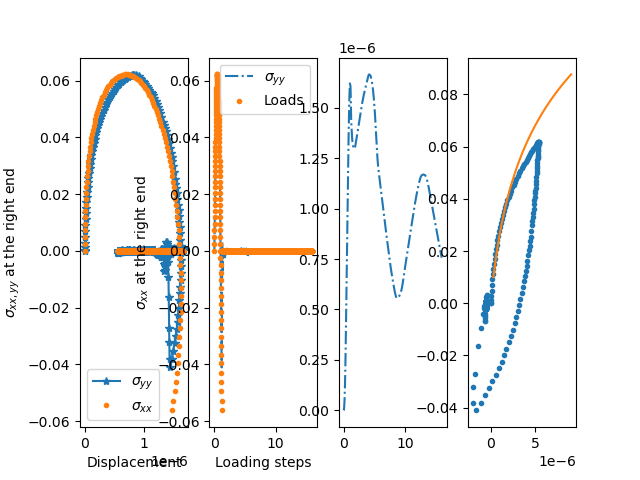

2246.4989979370825

In [33]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.plot(results[:, 0], results[:, 1], "-*")
plt.plot(results[:, 0], results[:, 3]*0.5*2*q_lim, ".")
plt.xlabel("Displacement")
plt.ylabel("$\sigma_{xx,yy}$ at the right end")
plt.legend(["$\sigma_{yy}$","$\sigma_{xx}$","Loads"])
plt.subplot(1,4,2)
plt.plot(results[:, 2], results[:, 1], "-.")
plt.plot(results[:, 2], results[:, 3]*0.5*2*q_lim, ".")
plt.xlabel("Loading steps")
plt.ylabel("$\sigma_{xx}$ at the right end")
plt.legend(["$\sigma_{yy}$","Loads"])
plt.subplot(1,4,3)
plt.plot(results[:, 2], results[:, 0], "-.")
plt.subplot(1,4,4)
plt.plot(results[:, 4], results[:, 1], ".")
plt.plot(sample_MP*strain_ref_MP,sqrt(2)*k_MP)
plt.show()

results[100, 1]/results[100, 4]

In [26]:
# plt.plot(results[:, 2],results_2d[:, 1], "-")

<IPython.core.display.Javascript object>


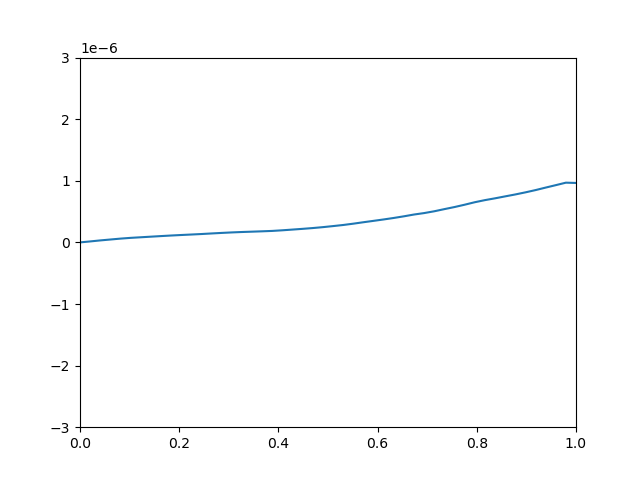

In [34]:
fig, ax = plt.subplots()

line, = ax.plot([])

ax.set_xlim(0,1)
ax.set_ylim(-0.3e-5,0.3e-5)

def animate(frame_num):
    # ax.clear()
    line.set_data((np.linspace(0,1,50), results_1d[frame_num, :]))
    return line

ani = FuncAnimation(fig, animate, frames=Nincr, interval=5)


plt.show()